In [4]:
import ipynb_setup

from src.data_loader.data_loader import Dataset

from src.model.catboost_model import CatBoost
from src.model.adaboost import AdaBoost
from src.model.extra_tree import ExtraTree
from src.model.lgbm import LGBM
from src.model.xgb import XGB

from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import GridSearchCV

In [2]:
CATEGORICAL_FEATURES = ['Condition', 'Clouds', 'Day/Night', 'Snow_Priority']
dataset = Dataset('../data/processed/merged_data_2.csv', CATEGORICAL_FEATURES)
x, x_test, y, y_test = dataset.clean_and_encode_data()
len(x), len(x_test)

/home/djordje/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Columns: ['FeelsLike', 'Precip.', 'StreetWidth_Min', 'POSTED_SPEED', 'Number_Travel_Lanes', 'Number_Park_Lanes', 'Number_Total_Lanes', 'LL_X', 'LL_Y', 'LL_Z', 'HOUR_SIN', 'HOUR_COS', 'MONTH_SIN', 'MONTH_COS', 'DOW_SIN', 'DOW_COS', 'Condition_CLD', 'Condition_LVS', 'Condition_RD', 'Clouds_BKN', 'Clouds_CLR', 'Clouds_FEW', 'Clouds_OVC', 'Clouds_SCT', 'Day/Night_D', 'Day/Night_N', 'Snow_Priority_C', 'Snow_Priority_H', 'Snow_Priority_S', 'Snow_Priority_V']


(653906, 72657)

In [17]:
cat = CatBoost(auto_class_weights='Balanced', verbose=50)
ada = AdaBoost()
extra_tree = ExtraTree(class_weight='balanced', verbose=50)
lgbm = LGBM(class_weight='balanced', verbose=50)
xgb = XGB(objective='multi:softmax', random_state=42,
          eval_metric='merror', num_class=2,
          use_label_encoder=False)

[21:57:14] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 
 0.6751586220185254 
 F1: 
 0.6751586220185254 
 F1_2: 
 0.6932327456253862 
 Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.76      0.79     58912
           1       0.24      0.33      0.28     13745

    accuracy                           0.68     72657
   macro avg       0.53      0.54      0.53     72657
weighted avg       0.72      0.68      0.69     72657

[[44560  9250]
 [14352  4495]]


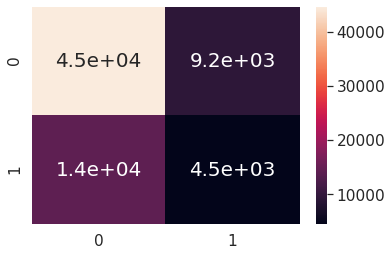

In [45]:
from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold

class_weights = compute_sample_weight('balanced', y[:100000])

xgb1 = XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'multi:softmax',
    nthread=4,
    seed=27,
    num_class=2,
    use_label_encoder=False
)

xgb1.fit(x[:100000], y[:100000], sample_weight=class_weights)

prediction = xgb1.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

In [49]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'multi:softmax',
    nthread=4,
    seed=27,
    num_class=2,
    use_label_encoder=False), param_grid = param_test1, n_jobs=4)

gsearch1.fit(x[:100000], y[:100000], sample_weight=class_weights)
                        
gsearch1.best_params_, gsearch1.best_score_

[23:37:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [50]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 9, 'min_child_weight': 1}, 0.64843)

Accuracy: 
 0.6437232475879819 
 F1: 
 0.6437232475879819 
 F1_2: 
 0.6760164040318576 
 Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.69      0.76     58912
           1       0.25      0.45      0.32     13745

    accuracy                           0.64     72657
   macro avg       0.55      0.57      0.54     72657
weighted avg       0.73      0.64      0.68     72657

[[40561  7535]
 [18351  6210]]


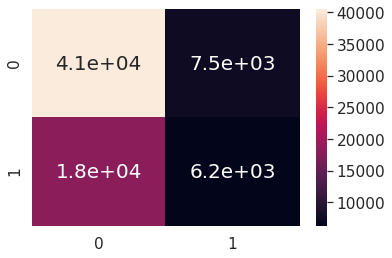

In [51]:
prediction = gsearch1.best_estimator_.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

## 1 step up and down

In [65]:
import numpy as np

param_test2 = {
 'max_depth':[8, 9, 10, 12],
}

class_weights = compute_sample_weight('balanced', y[:100000])

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
    min_child_weight=1,
    gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'multi:softmax',
    num_class=2,
    nthread=4,
    seed=27,
    use_label_encoder=False), param_grid = param_test2, n_jobs=-1)

gsearch1.fit(x[:100000], y[:100000], sample_weight=class_weights)
                        
gsearch1.best_params_, gsearch1.best_score_

[15:45:58] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'max_depth': 12}, 0.71478)

Accuracy: 
 0.7072133448945043 
 F1: 
 0.7072133448945043 
 F1_2: 
 0.7148037581505668 
 Classification report: 
               precision    recall  f1-score   support

           0       0.83      0.80      0.82     58912
           1       0.26      0.30      0.28     13745

    accuracy                           0.71     72657
   macro avg       0.55      0.55      0.55     72657
weighted avg       0.72      0.71      0.71     72657

[[47247  9608]
 [11665  4137]]


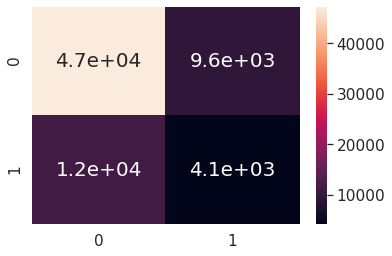

In [66]:
prediction = gsearch1.best_estimator_.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

## GAMMA

In [67]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

class_weights = compute_sample_weight('balanced', y[:100000])

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=9,
    min_child_weight=1,
    gamma=0, subsample=0.8, colsample_bytree=0.8,
    objective= 'multi:softmax',
    num_class=2,
    nthread=4,
    seed=27,
    use_label_encoder=False), param_grid = param_test3, n_jobs=-1)

gsearch1.fit(x[:100000], y[:100000], sample_weight=class_weights)
                        
gsearch1.best_params_, gsearch1.best_score_

[16:33:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


({'gamma': 0.3}, 0.6494300000000001)

Accuracy: 
 0.644122383252818 
 F1: 
 0.644122383252818 
 F1_2: 
 0.6765626169507943 
 Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.69      0.76     58912
           1       0.25      0.46      0.33     13745

    accuracy                           0.64     72657
   macro avg       0.55      0.57      0.54     72657
weighted avg       0.73      0.64      0.68     72657

[[40514  7459]
 [18398  6286]]


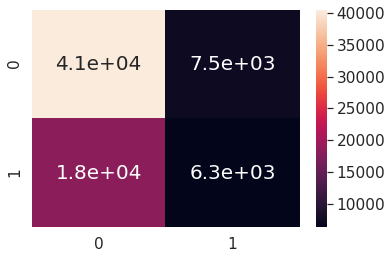

In [68]:
prediction = gsearch1.best_estimator_.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

# more rounds - the best one

[16:57:56] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.68942
[1]	validation_0-mlogloss:0.68629
[2]	validation_0-mlogloss:0.68377
[3]	validation_0-mlogloss:0.68157
[4]	validation_0-mlogloss:0.67973
[5]	validation_0-mlogloss:0.67824
[6]	validation_0-mlogloss:0.67683
[7]	validation_0-mlogloss:0.67565
[8]	validation_0-mlogloss:0.67458
[9]	validation_0-mlogloss:0.67369
[10]	validation_0-mlogloss:0.67283
[11]	validation_0-mlogloss:0.67215
[12]	validation_0-mlogloss:0.67154
[13]	validation_0-mlogloss:0.67100
[14]	validation_0-mlogloss:0.67043
[15]	validation_0-mlogloss:0.67003
[16]	validation_0-mlogloss:0.66956
[17]	validation_0-mlogloss:0.66915
[18]	validation_0-mlogloss:0.66877
[19]	validation_0-mlogloss:0.66836
[20]	validation_0-mlogloss:0.66800
[21]	validation_0-mlogl

[224]	validation_0-mlogloss:0.64852
[225]	validation_0-mlogloss:0.64850
[226]	validation_0-mlogloss:0.64845
[227]	validation_0-mlogloss:0.64835
[228]	validation_0-mlogloss:0.64821
[229]	validation_0-mlogloss:0.64823
[230]	validation_0-mlogloss:0.64820
[231]	validation_0-mlogloss:0.64816
[232]	validation_0-mlogloss:0.64813
[233]	validation_0-mlogloss:0.64806
[234]	validation_0-mlogloss:0.64803
[235]	validation_0-mlogloss:0.64802
[236]	validation_0-mlogloss:0.64797
[237]	validation_0-mlogloss:0.64795
[238]	validation_0-mlogloss:0.64789
[239]	validation_0-mlogloss:0.64781
[240]	validation_0-mlogloss:0.64770
[241]	validation_0-mlogloss:0.64761
[242]	validation_0-mlogloss:0.64748
[243]	validation_0-mlogloss:0.64737
[244]	validation_0-mlogloss:0.64734
[245]	validation_0-mlogloss:0.64732
[246]	validation_0-mlogloss:0.64724
[247]	validation_0-mlogloss:0.64721
[248]	validation_0-mlogloss:0.64713
[249]	validation_0-mlogloss:0.64701
[250]	validation_0-mlogloss:0.64698
[251]	validation_0-mlogloss:

[452]	validation_0-mlogloss:0.63563
[453]	validation_0-mlogloss:0.63558
[454]	validation_0-mlogloss:0.63556
[455]	validation_0-mlogloss:0.63550
[456]	validation_0-mlogloss:0.63546
[457]	validation_0-mlogloss:0.63541
[458]	validation_0-mlogloss:0.63536
[459]	validation_0-mlogloss:0.63531
[460]	validation_0-mlogloss:0.63531
[461]	validation_0-mlogloss:0.63520
[462]	validation_0-mlogloss:0.63510
[463]	validation_0-mlogloss:0.63507
[464]	validation_0-mlogloss:0.63505
[465]	validation_0-mlogloss:0.63496
[466]	validation_0-mlogloss:0.63488
[467]	validation_0-mlogloss:0.63475
[468]	validation_0-mlogloss:0.63475
[469]	validation_0-mlogloss:0.63466
[470]	validation_0-mlogloss:0.63463
[471]	validation_0-mlogloss:0.63459
[472]	validation_0-mlogloss:0.63452
[473]	validation_0-mlogloss:0.63446
[474]	validation_0-mlogloss:0.63440
[475]	validation_0-mlogloss:0.63438
[476]	validation_0-mlogloss:0.63432
[477]	validation_0-mlogloss:0.63425
[478]	validation_0-mlogloss:0.63419
[479]	validation_0-mlogloss:

[680]	validation_0-mlogloss:0.62484
[681]	validation_0-mlogloss:0.62481
[682]	validation_0-mlogloss:0.62477
[683]	validation_0-mlogloss:0.62474
[684]	validation_0-mlogloss:0.62462
[685]	validation_0-mlogloss:0.62456
[686]	validation_0-mlogloss:0.62453
[687]	validation_0-mlogloss:0.62448
[688]	validation_0-mlogloss:0.62447
[689]	validation_0-mlogloss:0.62440
[690]	validation_0-mlogloss:0.62438
[691]	validation_0-mlogloss:0.62434
[692]	validation_0-mlogloss:0.62427
[693]	validation_0-mlogloss:0.62424
[694]	validation_0-mlogloss:0.62420
[695]	validation_0-mlogloss:0.62418
[696]	validation_0-mlogloss:0.62415
[697]	validation_0-mlogloss:0.62410
[698]	validation_0-mlogloss:0.62404
[699]	validation_0-mlogloss:0.62400
[700]	validation_0-mlogloss:0.62396
[701]	validation_0-mlogloss:0.62389
[702]	validation_0-mlogloss:0.62384
[703]	validation_0-mlogloss:0.62382
[704]	validation_0-mlogloss:0.62382
[705]	validation_0-mlogloss:0.62373
[706]	validation_0-mlogloss:0.62371
[707]	validation_0-mlogloss:

[908]	validation_0-mlogloss:0.61517
[909]	validation_0-mlogloss:0.61513
[910]	validation_0-mlogloss:0.61510
[911]	validation_0-mlogloss:0.61507
[912]	validation_0-mlogloss:0.61505
[913]	validation_0-mlogloss:0.61500
[914]	validation_0-mlogloss:0.61498
[915]	validation_0-mlogloss:0.61498
[916]	validation_0-mlogloss:0.61498
[917]	validation_0-mlogloss:0.61497
[918]	validation_0-mlogloss:0.61492
[919]	validation_0-mlogloss:0.61486
[920]	validation_0-mlogloss:0.61484
[921]	validation_0-mlogloss:0.61484
[922]	validation_0-mlogloss:0.61479
[923]	validation_0-mlogloss:0.61469
[924]	validation_0-mlogloss:0.61464
[925]	validation_0-mlogloss:0.61460
[926]	validation_0-mlogloss:0.61459
[927]	validation_0-mlogloss:0.61455
[928]	validation_0-mlogloss:0.61447
[929]	validation_0-mlogloss:0.61447
[930]	validation_0-mlogloss:0.61440
[931]	validation_0-mlogloss:0.61439
[932]	validation_0-mlogloss:0.61437
[933]	validation_0-mlogloss:0.61437
[934]	validation_0-mlogloss:0.61433
[935]	validation_0-mlogloss:

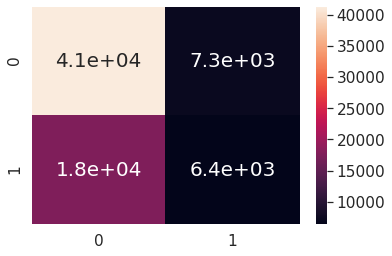

In [73]:
class_weights = compute_sample_weight('balanced', y)

xgb = XGBClassifier(learning_rate=0.1, 
                    n_estimators=1000, 
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0.3, 
                    subsample=0.8, 
                    colsample_bytree=0.8,
                    objective= 'multi:softmax',
                    num_class=2,
                    nthread=4,
                    seed=27,
                    use_label_encoder=False)


xgb.fit(x, y, sample_weight=class_weights, early_stopping_rounds=20, eval_set=[(x_test, y_test)])

prediction = xgb.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

In [ ]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [ ]:
from xgboost import plot_tree

# make sure to "sudo apt-get install graphviz" before runnning
fig, ax = plt.subplots(figsize=(900, 900))
plot_tree(xgb, num_trees=1, ax=ax)

plt.tight_layout()
plt.savefig("tree_structure.pdf")
plt.show()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.293651 to fit


## subsample and colsample_bytree

In [5]:
param_test3 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}

class_weights = compute_sample_weight('balanced', y[:100000])

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=9,
    min_child_weight=1,
    gamma=0.3, subsample=0.8, colsample_bytree=0.8,
    objective= 'multi:softmax',
    num_class=2,
    nthread=4,
    seed=27,
    use_label_encoder=False), param_grid = param_test3, n_jobs=-1)

gsearch1.fit(x[:100000], y[:100000], sample_weight=class_weights, 
             early_stopping_rounds=20, eval_set=[(x_test, y_test)])
                        
gsearch1.best_params_, gsearch1.best_score_

[20:19:03] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.68853
[1]	validation_0-mlogloss:0.68518
[2]	validation_0-mlogloss:0.68153
[3]	validation_0-mlogloss:0.67869
[4]	validation_0-mlogloss:0.67604
[5]	validation_0-mlogloss:0.67334
[6]	validation_0-mlogloss:0.67082
[7]	validation_0-mlogloss:0.66915
[8]	validation_0-mlogloss:0.66745
[9]	validation_0-mlogloss:0.66578
[10]	validation_0-mlogloss:0.66418
[11]	validation_0-mlogloss:0.66278
[12]	validation_0-mlogloss:0.66180
[13]	validation_0-mlogloss:0.66071
[14]	validation_0-mlogloss:0.65971
[15]	validation_0-mlogloss:0.65904
[16]	validation_0-mlogloss:0.65830
[17]	validation_0-mlogloss:0.65768
[18]	validation_0-mlogloss:0.65677
[19]	validation_0-mlogloss:0.65605
[20]	validation_0-mlogloss:0.65522
[21]	validation_0-mlogl

({'colsample_bytree': 0.7, 'subsample': 0.7}, 0.65061)

Accuracy: 
 0.6424707873983236 
 F1: 
 0.6424707873983236 
 F1_2: 
 0.6752060089401348 
 Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.69      0.76     58912
           1       0.25      0.46      0.33     13745

    accuracy                           0.64     72657
   macro avg       0.55      0.57      0.54     72657
weighted avg       0.73      0.64      0.68     72657

[[40405  7470]
 [18507  6275]]


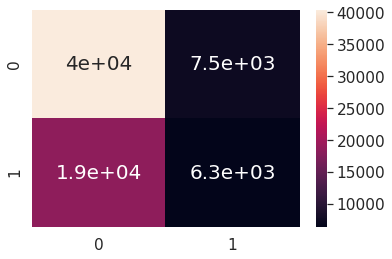

In [10]:
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

prediction = gsearch1.best_estimator_.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

## reg_alpha

In [11]:
param_test4 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

class_weights = compute_sample_weight('balanced', y[:100000])

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=140, 
                        max_depth=9,
                        min_child_weight=1,
                        gamma=0.3, 
                        subsample=0.7, 
                        colsample_bytree=0.7,
                        objective='multi:softmax',
                        num_class=2,
                        nthread=4,
                        seed=27,
                        use_label_encoder=False), param_grid = param_test4, n_jobs=-1)

gsearch1.fit(x[:100000], y[:100000], sample_weight=class_weights, 
             early_stopping_rounds=20, eval_set=[(x_test, y_test)])
                        
gsearch1.best_params_, gsearch1.best_score_

[21:17:15] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.68853
[1]	validation_0-mlogloss:0.68518
[2]	validation_0-mlogloss:0.68153
[3]	validation_0-mlogloss:0.67869
[4]	validation_0-mlogloss:0.67604
[5]	validation_0-mlogloss:0.67334
[6]	validation_0-mlogloss:0.67082
[7]	validation_0-mlogloss:0.66915
[8]	validation_0-mlogloss:0.66745
[9]	validation_0-mlogloss:0.66578
[10]	validation_0-mlogloss:0.66418
[11]	validation_0-mlogloss:0.66278
[12]	validation_0-mlogloss:0.66180
[13]	validation_0-mlogloss:0.66071
[14]	validation_0-mlogloss:0.65971
[15]	validation_0-mlogloss:0.65904
[16]	validation_0-mlogloss:0.65830
[17]	validation_0-mlogloss:0.65768
[18]	validation_0-mlogloss:0.65677
[19]	validation_0-mlogloss:0.65605
[20]	validation_0-mlogloss:0.65522
[21]	validation_0-mlogl

({'reg_alpha': 0}, 0.65061)

Accuracy: 
 0.6424707873983236 
 F1: 
 0.6424707873983236 
 F1_2: 
 0.6752060089401348 
 Classification report: 
               precision    recall  f1-score   support

           0       0.84      0.69      0.76     58912
           1       0.25      0.46      0.33     13745

    accuracy                           0.64     72657
   macro avg       0.55      0.57      0.54     72657
weighted avg       0.73      0.64      0.68     72657

[[40405  7470]
 [18507  6275]]


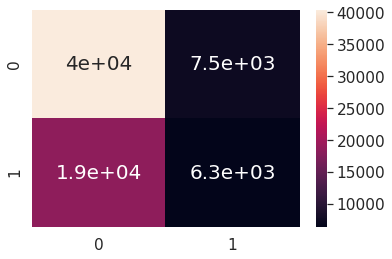

In [12]:
prediction = gsearch1.best_estimator_.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

# lower lr more trees

In [27]:
#[50]	validation_0-mlogloss:0.66254 - 0.1
#[50]	validation_0-mlogloss:0.65829 - 0.2
#[50]	validation_0-mlogloss:0.65506 - 0.4
class_weights = compute_sample_weight('balanced', y)

xgb = XGBClassifier(learning_rate=0.01, 
                    n_estimators=5000, 
                    max_depth=9,
                    min_child_weight=1,
                    gamma=0.3, 
                    subsample=0.7, 
                    colsample_bytree=0.7,
                    objective='multi:softmax',
                    num_class=2,
                    nthread=4,
                    seed=27,
                    use_label_encoder=False)

xgb.fit(x, y, sample_weight=class_weights, 
             early_stopping_rounds=20, eval_set=[(x_test, y_test)])

[23:25:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-mlogloss:0.69279
[1]	validation_0-mlogloss:0.69244
[2]	validation_0-mlogloss:0.69206
[3]	validation_0-mlogloss:0.69174
[4]	validation_0-mlogloss:0.69141
[5]	validation_0-mlogloss:0.69112
[6]	validation_0-mlogloss:0.69078
[7]	validation_0-mlogloss:0.69044
[8]	validation_0-mlogloss:0.69012
[9]	validation_0-mlogloss:0.68982
[10]	validation_0-mlogloss:0.68949
[11]	validation_0-mlogloss:0.68918
[12]	validation_0-mlogloss:0.68887
[13]	validation_0-mlogloss:0.68857
[14]	validation_0-mlogloss:0.68830
[15]	validation_0-mlogloss:0.68802
[16]	validation_0-mlogloss:0.68772
[17]	validation_0-mlogloss:0.68743
[18]	validation_0-mlogloss:0.68719
[19]	validation_0-mlogloss:0.68690
[20]	validation_0-mlogloss:0.68662
[21]	validation_0-mlogl

[224]	validation_0-mlogloss:0.66708
[225]	validation_0-mlogloss:0.66705
[226]	validation_0-mlogloss:0.66702
[227]	validation_0-mlogloss:0.66699
[228]	validation_0-mlogloss:0.66695
[229]	validation_0-mlogloss:0.66692
[230]	validation_0-mlogloss:0.66689
[231]	validation_0-mlogloss:0.66686
[232]	validation_0-mlogloss:0.66683
[233]	validation_0-mlogloss:0.66680
[234]	validation_0-mlogloss:0.66678
[235]	validation_0-mlogloss:0.66676
[236]	validation_0-mlogloss:0.66673
[237]	validation_0-mlogloss:0.66670
[238]	validation_0-mlogloss:0.66666
[239]	validation_0-mlogloss:0.66664
[240]	validation_0-mlogloss:0.66661
[241]	validation_0-mlogloss:0.66658
[242]	validation_0-mlogloss:0.66654
[243]	validation_0-mlogloss:0.66651
[244]	validation_0-mlogloss:0.66647
[245]	validation_0-mlogloss:0.66645
[246]	validation_0-mlogloss:0.66641
[247]	validation_0-mlogloss:0.66639
[248]	validation_0-mlogloss:0.66635
[249]	validation_0-mlogloss:0.66630
[250]	validation_0-mlogloss:0.66628
[251]	validation_0-mlogloss:

[452]	validation_0-mlogloss:0.66210
[453]	validation_0-mlogloss:0.66210
[454]	validation_0-mlogloss:0.66209
[455]	validation_0-mlogloss:0.66208
[456]	validation_0-mlogloss:0.66207
[457]	validation_0-mlogloss:0.66206
[458]	validation_0-mlogloss:0.66204
[459]	validation_0-mlogloss:0.66203
[460]	validation_0-mlogloss:0.66203
[461]	validation_0-mlogloss:0.66201
[462]	validation_0-mlogloss:0.66198
[463]	validation_0-mlogloss:0.66197
[464]	validation_0-mlogloss:0.66195
[465]	validation_0-mlogloss:0.66194
[466]	validation_0-mlogloss:0.66192
[467]	validation_0-mlogloss:0.66190
[468]	validation_0-mlogloss:0.66189
[469]	validation_0-mlogloss:0.66188
[470]	validation_0-mlogloss:0.66187
[471]	validation_0-mlogloss:0.66185
[472]	validation_0-mlogloss:0.66184
[473]	validation_0-mlogloss:0.66182
[474]	validation_0-mlogloss:0.66182
[475]	validation_0-mlogloss:0.66180
[476]	validation_0-mlogloss:0.66179
[477]	validation_0-mlogloss:0.66178
[478]	validation_0-mlogloss:0.66176
[479]	validation_0-mlogloss:

[680]	validation_0-mlogloss:0.65952
[681]	validation_0-mlogloss:0.65951
[682]	validation_0-mlogloss:0.65950
[683]	validation_0-mlogloss:0.65949
[684]	validation_0-mlogloss:0.65947
[685]	validation_0-mlogloss:0.65947
[686]	validation_0-mlogloss:0.65946
[687]	validation_0-mlogloss:0.65944
[688]	validation_0-mlogloss:0.65943
[689]	validation_0-mlogloss:0.65942
[690]	validation_0-mlogloss:0.65942
[691]	validation_0-mlogloss:0.65940
[692]	validation_0-mlogloss:0.65940
[693]	validation_0-mlogloss:0.65939
[694]	validation_0-mlogloss:0.65938
[695]	validation_0-mlogloss:0.65938
[696]	validation_0-mlogloss:0.65938
[697]	validation_0-mlogloss:0.65938
[698]	validation_0-mlogloss:0.65937
[699]	validation_0-mlogloss:0.65936
[700]	validation_0-mlogloss:0.65936
[701]	validation_0-mlogloss:0.65934
[702]	validation_0-mlogloss:0.65933
[703]	validation_0-mlogloss:0.65932
[704]	validation_0-mlogloss:0.65931
[705]	validation_0-mlogloss:0.65929
[706]	validation_0-mlogloss:0.65929
[707]	validation_0-mlogloss:

[908]	validation_0-mlogloss:0.65743
[909]	validation_0-mlogloss:0.65743
[910]	validation_0-mlogloss:0.65743
[911]	validation_0-mlogloss:0.65742
[912]	validation_0-mlogloss:0.65741
[913]	validation_0-mlogloss:0.65738
[914]	validation_0-mlogloss:0.65737
[915]	validation_0-mlogloss:0.65737
[916]	validation_0-mlogloss:0.65736
[917]	validation_0-mlogloss:0.65736
[918]	validation_0-mlogloss:0.65735
[919]	validation_0-mlogloss:0.65734
[920]	validation_0-mlogloss:0.65733
[921]	validation_0-mlogloss:0.65733
[922]	validation_0-mlogloss:0.65731
[923]	validation_0-mlogloss:0.65729
[924]	validation_0-mlogloss:0.65728
[925]	validation_0-mlogloss:0.65727
[926]	validation_0-mlogloss:0.65727
[927]	validation_0-mlogloss:0.65726
[928]	validation_0-mlogloss:0.65723
[929]	validation_0-mlogloss:0.65723
[930]	validation_0-mlogloss:0.65721
[931]	validation_0-mlogloss:0.65721
[932]	validation_0-mlogloss:0.65721
[933]	validation_0-mlogloss:0.65720
[934]	validation_0-mlogloss:0.65719
[935]	validation_0-mlogloss:

[1132]	validation_0-mlogloss:0.65553
[1133]	validation_0-mlogloss:0.65553
[1134]	validation_0-mlogloss:0.65552
[1135]	validation_0-mlogloss:0.65551
[1136]	validation_0-mlogloss:0.65550
[1137]	validation_0-mlogloss:0.65549
[1138]	validation_0-mlogloss:0.65548
[1139]	validation_0-mlogloss:0.65548
[1140]	validation_0-mlogloss:0.65546
[1141]	validation_0-mlogloss:0.65546
[1142]	validation_0-mlogloss:0.65545
[1143]	validation_0-mlogloss:0.65544
[1144]	validation_0-mlogloss:0.65544
[1145]	validation_0-mlogloss:0.65543
[1146]	validation_0-mlogloss:0.65542
[1147]	validation_0-mlogloss:0.65541
[1148]	validation_0-mlogloss:0.65542
[1149]	validation_0-mlogloss:0.65541
[1150]	validation_0-mlogloss:0.65540
[1151]	validation_0-mlogloss:0.65539
[1152]	validation_0-mlogloss:0.65538
[1153]	validation_0-mlogloss:0.65537
[1154]	validation_0-mlogloss:0.65536
[1155]	validation_0-mlogloss:0.65535
[1156]	validation_0-mlogloss:0.65534
[1157]	validation_0-mlogloss:0.65533
[1158]	validation_0-mlogloss:0.65532
[

[1354]	validation_0-mlogloss:0.65387
[1355]	validation_0-mlogloss:0.65386
[1356]	validation_0-mlogloss:0.65385
[1357]	validation_0-mlogloss:0.65384
[1358]	validation_0-mlogloss:0.65383
[1359]	validation_0-mlogloss:0.65382
[1360]	validation_0-mlogloss:0.65381
[1361]	validation_0-mlogloss:0.65380
[1362]	validation_0-mlogloss:0.65379
[1363]	validation_0-mlogloss:0.65379
[1364]	validation_0-mlogloss:0.65378
[1365]	validation_0-mlogloss:0.65377
[1366]	validation_0-mlogloss:0.65376
[1367]	validation_0-mlogloss:0.65375
[1368]	validation_0-mlogloss:0.65374
[1369]	validation_0-mlogloss:0.65373
[1370]	validation_0-mlogloss:0.65372
[1371]	validation_0-mlogloss:0.65371
[1372]	validation_0-mlogloss:0.65371
[1373]	validation_0-mlogloss:0.65370
[1374]	validation_0-mlogloss:0.65369
[1375]	validation_0-mlogloss:0.65368
[1376]	validation_0-mlogloss:0.65367
[1377]	validation_0-mlogloss:0.65366
[1378]	validation_0-mlogloss:0.65366
[1379]	validation_0-mlogloss:0.65366
[1380]	validation_0-mlogloss:0.65365
[

[1576]	validation_0-mlogloss:0.65218
[1577]	validation_0-mlogloss:0.65217
[1578]	validation_0-mlogloss:0.65217
[1579]	validation_0-mlogloss:0.65216
[1580]	validation_0-mlogloss:0.65215
[1581]	validation_0-mlogloss:0.65215
[1582]	validation_0-mlogloss:0.65215
[1583]	validation_0-mlogloss:0.65214
[1584]	validation_0-mlogloss:0.65214
[1585]	validation_0-mlogloss:0.65214
[1586]	validation_0-mlogloss:0.65213
[1587]	validation_0-mlogloss:0.65212
[1588]	validation_0-mlogloss:0.65211
[1589]	validation_0-mlogloss:0.65210
[1590]	validation_0-mlogloss:0.65209
[1591]	validation_0-mlogloss:0.65208
[1592]	validation_0-mlogloss:0.65207
[1593]	validation_0-mlogloss:0.65206
[1594]	validation_0-mlogloss:0.65206
[1595]	validation_0-mlogloss:0.65205
[1596]	validation_0-mlogloss:0.65203
[1597]	validation_0-mlogloss:0.65203
[1598]	validation_0-mlogloss:0.65202
[1599]	validation_0-mlogloss:0.65202
[1600]	validation_0-mlogloss:0.65202
[1601]	validation_0-mlogloss:0.65200
[1602]	validation_0-mlogloss:0.65200
[

[1798]	validation_0-mlogloss:0.65063
[1799]	validation_0-mlogloss:0.65062
[1800]	validation_0-mlogloss:0.65061
[1801]	validation_0-mlogloss:0.65061
[1802]	validation_0-mlogloss:0.65059
[1803]	validation_0-mlogloss:0.65057
[1804]	validation_0-mlogloss:0.65056
[1805]	validation_0-mlogloss:0.65055
[1806]	validation_0-mlogloss:0.65054
[1807]	validation_0-mlogloss:0.65053
[1808]	validation_0-mlogloss:0.65052
[1809]	validation_0-mlogloss:0.65051
[1810]	validation_0-mlogloss:0.65049
[1811]	validation_0-mlogloss:0.65049
[1812]	validation_0-mlogloss:0.65049
[1813]	validation_0-mlogloss:0.65048
[1814]	validation_0-mlogloss:0.65047
[1815]	validation_0-mlogloss:0.65046
[1816]	validation_0-mlogloss:0.65045
[1817]	validation_0-mlogloss:0.65044
[1818]	validation_0-mlogloss:0.65043
[1819]	validation_0-mlogloss:0.65043
[1820]	validation_0-mlogloss:0.65043
[1821]	validation_0-mlogloss:0.65043
[1822]	validation_0-mlogloss:0.65041
[1823]	validation_0-mlogloss:0.65041
[1824]	validation_0-mlogloss:0.65040
[

[2020]	validation_0-mlogloss:0.64903
[2021]	validation_0-mlogloss:0.64903
[2022]	validation_0-mlogloss:0.64902
[2023]	validation_0-mlogloss:0.64901
[2024]	validation_0-mlogloss:0.64899
[2025]	validation_0-mlogloss:0.64899
[2026]	validation_0-mlogloss:0.64899
[2027]	validation_0-mlogloss:0.64898
[2028]	validation_0-mlogloss:0.64898
[2029]	validation_0-mlogloss:0.64896
[2030]	validation_0-mlogloss:0.64895
[2031]	validation_0-mlogloss:0.64895
[2032]	validation_0-mlogloss:0.64894
[2033]	validation_0-mlogloss:0.64893
[2034]	validation_0-mlogloss:0.64891
[2035]	validation_0-mlogloss:0.64891
[2036]	validation_0-mlogloss:0.64892
[2037]	validation_0-mlogloss:0.64891
[2038]	validation_0-mlogloss:0.64889
[2039]	validation_0-mlogloss:0.64888
[2040]	validation_0-mlogloss:0.64887
[2041]	validation_0-mlogloss:0.64886
[2042]	validation_0-mlogloss:0.64885
[2043]	validation_0-mlogloss:0.64883
[2044]	validation_0-mlogloss:0.64883
[2045]	validation_0-mlogloss:0.64882
[2046]	validation_0-mlogloss:0.64881
[

[2242]	validation_0-mlogloss:0.64746
[2243]	validation_0-mlogloss:0.64745
[2244]	validation_0-mlogloss:0.64744
[2245]	validation_0-mlogloss:0.64744
[2246]	validation_0-mlogloss:0.64743
[2247]	validation_0-mlogloss:0.64743
[2248]	validation_0-mlogloss:0.64743
[2249]	validation_0-mlogloss:0.64742
[2250]	validation_0-mlogloss:0.64742
[2251]	validation_0-mlogloss:0.64742
[2252]	validation_0-mlogloss:0.64741
[2253]	validation_0-mlogloss:0.64741
[2254]	validation_0-mlogloss:0.64741
[2255]	validation_0-mlogloss:0.64740
[2256]	validation_0-mlogloss:0.64740
[2257]	validation_0-mlogloss:0.64739
[2258]	validation_0-mlogloss:0.64738
[2259]	validation_0-mlogloss:0.64737
[2260]	validation_0-mlogloss:0.64736
[2261]	validation_0-mlogloss:0.64736
[2262]	validation_0-mlogloss:0.64735
[2263]	validation_0-mlogloss:0.64735
[2264]	validation_0-mlogloss:0.64734
[2265]	validation_0-mlogloss:0.64732
[2266]	validation_0-mlogloss:0.64732
[2267]	validation_0-mlogloss:0.64731
[2268]	validation_0-mlogloss:0.64731
[

[2464]	validation_0-mlogloss:0.64600
[2465]	validation_0-mlogloss:0.64599
[2466]	validation_0-mlogloss:0.64599
[2467]	validation_0-mlogloss:0.64598
[2468]	validation_0-mlogloss:0.64598
[2469]	validation_0-mlogloss:0.64597
[2470]	validation_0-mlogloss:0.64597
[2471]	validation_0-mlogloss:0.64596
[2472]	validation_0-mlogloss:0.64596
[2473]	validation_0-mlogloss:0.64595
[2474]	validation_0-mlogloss:0.64595
[2475]	validation_0-mlogloss:0.64594
[2476]	validation_0-mlogloss:0.64593
[2477]	validation_0-mlogloss:0.64593
[2478]	validation_0-mlogloss:0.64592
[2479]	validation_0-mlogloss:0.64592
[2480]	validation_0-mlogloss:0.64592
[2481]	validation_0-mlogloss:0.64592
[2482]	validation_0-mlogloss:0.64590
[2483]	validation_0-mlogloss:0.64589
[2484]	validation_0-mlogloss:0.64588
[2485]	validation_0-mlogloss:0.64587
[2486]	validation_0-mlogloss:0.64587
[2487]	validation_0-mlogloss:0.64586
[2488]	validation_0-mlogloss:0.64586
[2489]	validation_0-mlogloss:0.64585
[2490]	validation_0-mlogloss:0.64585
[

[2686]	validation_0-mlogloss:0.64462
[2687]	validation_0-mlogloss:0.64462
[2688]	validation_0-mlogloss:0.64462
[2689]	validation_0-mlogloss:0.64463
[2690]	validation_0-mlogloss:0.64462
[2691]	validation_0-mlogloss:0.64462
[2692]	validation_0-mlogloss:0.64462
[2693]	validation_0-mlogloss:0.64460
[2694]	validation_0-mlogloss:0.64460
[2695]	validation_0-mlogloss:0.64460
[2696]	validation_0-mlogloss:0.64459
[2697]	validation_0-mlogloss:0.64457
[2698]	validation_0-mlogloss:0.64457
[2699]	validation_0-mlogloss:0.64457
[2700]	validation_0-mlogloss:0.64456
[2701]	validation_0-mlogloss:0.64455
[2702]	validation_0-mlogloss:0.64455
[2703]	validation_0-mlogloss:0.64455
[2704]	validation_0-mlogloss:0.64454
[2705]	validation_0-mlogloss:0.64453
[2706]	validation_0-mlogloss:0.64451
[2707]	validation_0-mlogloss:0.64451
[2708]	validation_0-mlogloss:0.64450
[2709]	validation_0-mlogloss:0.64450
[2710]	validation_0-mlogloss:0.64448
[2711]	validation_0-mlogloss:0.64448
[2712]	validation_0-mlogloss:0.64447
[

[2908]	validation_0-mlogloss:0.64321
[2909]	validation_0-mlogloss:0.64321
[2910]	validation_0-mlogloss:0.64320
[2911]	validation_0-mlogloss:0.64320
[2912]	validation_0-mlogloss:0.64319
[2913]	validation_0-mlogloss:0.64319
[2914]	validation_0-mlogloss:0.64318
[2915]	validation_0-mlogloss:0.64317
[2916]	validation_0-mlogloss:0.64317
[2917]	validation_0-mlogloss:0.64316
[2918]	validation_0-mlogloss:0.64315
[2919]	validation_0-mlogloss:0.64314
[2920]	validation_0-mlogloss:0.64313
[2921]	validation_0-mlogloss:0.64313
[2922]	validation_0-mlogloss:0.64312
[2923]	validation_0-mlogloss:0.64311
[2924]	validation_0-mlogloss:0.64310
[2925]	validation_0-mlogloss:0.64310
[2926]	validation_0-mlogloss:0.64310
[2927]	validation_0-mlogloss:0.64309
[2928]	validation_0-mlogloss:0.64308
[2929]	validation_0-mlogloss:0.64308
[2930]	validation_0-mlogloss:0.64307
[2931]	validation_0-mlogloss:0.64306
[2932]	validation_0-mlogloss:0.64307
[2933]	validation_0-mlogloss:0.64306
[2934]	validation_0-mlogloss:0.64306
[

[3130]	validation_0-mlogloss:0.64182
[3131]	validation_0-mlogloss:0.64181
[3132]	validation_0-mlogloss:0.64181
[3133]	validation_0-mlogloss:0.64180
[3134]	validation_0-mlogloss:0.64180
[3135]	validation_0-mlogloss:0.64179
[3136]	validation_0-mlogloss:0.64178
[3137]	validation_0-mlogloss:0.64177
[3138]	validation_0-mlogloss:0.64177
[3139]	validation_0-mlogloss:0.64177
[3140]	validation_0-mlogloss:0.64176
[3141]	validation_0-mlogloss:0.64176
[3142]	validation_0-mlogloss:0.64175
[3143]	validation_0-mlogloss:0.64175
[3144]	validation_0-mlogloss:0.64175
[3145]	validation_0-mlogloss:0.64174
[3146]	validation_0-mlogloss:0.64174
[3147]	validation_0-mlogloss:0.64173
[3148]	validation_0-mlogloss:0.64173
[3149]	validation_0-mlogloss:0.64173
[3150]	validation_0-mlogloss:0.64173
[3151]	validation_0-mlogloss:0.64172
[3152]	validation_0-mlogloss:0.64172
[3153]	validation_0-mlogloss:0.64171
[3154]	validation_0-mlogloss:0.64171
[3155]	validation_0-mlogloss:0.64172
[3156]	validation_0-mlogloss:0.64171
[

[3352]	validation_0-mlogloss:0.64053
[3353]	validation_0-mlogloss:0.64052
[3354]	validation_0-mlogloss:0.64051
[3355]	validation_0-mlogloss:0.64051
[3356]	validation_0-mlogloss:0.64049
[3357]	validation_0-mlogloss:0.64048
[3358]	validation_0-mlogloss:0.64048
[3359]	validation_0-mlogloss:0.64047
[3360]	validation_0-mlogloss:0.64048
[3361]	validation_0-mlogloss:0.64047
[3362]	validation_0-mlogloss:0.64047
[3363]	validation_0-mlogloss:0.64046
[3364]	validation_0-mlogloss:0.64045
[3365]	validation_0-mlogloss:0.64044
[3366]	validation_0-mlogloss:0.64043
[3367]	validation_0-mlogloss:0.64043
[3368]	validation_0-mlogloss:0.64042
[3369]	validation_0-mlogloss:0.64041
[3370]	validation_0-mlogloss:0.64042
[3371]	validation_0-mlogloss:0.64040
[3372]	validation_0-mlogloss:0.64040
[3373]	validation_0-mlogloss:0.64040
[3374]	validation_0-mlogloss:0.64038
[3375]	validation_0-mlogloss:0.64038
[3376]	validation_0-mlogloss:0.64038
[3377]	validation_0-mlogloss:0.64036
[3378]	validation_0-mlogloss:0.64036
[

[3574]	validation_0-mlogloss:0.63919
[3575]	validation_0-mlogloss:0.63919
[3576]	validation_0-mlogloss:0.63918
[3577]	validation_0-mlogloss:0.63918
[3578]	validation_0-mlogloss:0.63917
[3579]	validation_0-mlogloss:0.63916
[3580]	validation_0-mlogloss:0.63916
[3581]	validation_0-mlogloss:0.63916
[3582]	validation_0-mlogloss:0.63916
[3583]	validation_0-mlogloss:0.63915
[3584]	validation_0-mlogloss:0.63914
[3585]	validation_0-mlogloss:0.63914
[3586]	validation_0-mlogloss:0.63913
[3587]	validation_0-mlogloss:0.63912
[3588]	validation_0-mlogloss:0.63911
[3589]	validation_0-mlogloss:0.63911
[3590]	validation_0-mlogloss:0.63911
[3591]	validation_0-mlogloss:0.63911
[3592]	validation_0-mlogloss:0.63910
[3593]	validation_0-mlogloss:0.63910
[3594]	validation_0-mlogloss:0.63909
[3595]	validation_0-mlogloss:0.63908
[3596]	validation_0-mlogloss:0.63907
[3597]	validation_0-mlogloss:0.63907
[3598]	validation_0-mlogloss:0.63907
[3599]	validation_0-mlogloss:0.63906
[3600]	validation_0-mlogloss:0.63906
[

[3796]	validation_0-mlogloss:0.63791
[3797]	validation_0-mlogloss:0.63790
[3798]	validation_0-mlogloss:0.63790
[3799]	validation_0-mlogloss:0.63789
[3800]	validation_0-mlogloss:0.63789
[3801]	validation_0-mlogloss:0.63789
[3802]	validation_0-mlogloss:0.63788
[3803]	validation_0-mlogloss:0.63787
[3804]	validation_0-mlogloss:0.63786
[3805]	validation_0-mlogloss:0.63785
[3806]	validation_0-mlogloss:0.63785
[3807]	validation_0-mlogloss:0.63785
[3808]	validation_0-mlogloss:0.63784
[3809]	validation_0-mlogloss:0.63783
[3810]	validation_0-mlogloss:0.63783
[3811]	validation_0-mlogloss:0.63782
[3812]	validation_0-mlogloss:0.63781
[3813]	validation_0-mlogloss:0.63781
[3814]	validation_0-mlogloss:0.63781
[3815]	validation_0-mlogloss:0.63780
[3816]	validation_0-mlogloss:0.63780
[3817]	validation_0-mlogloss:0.63779
[3818]	validation_0-mlogloss:0.63779
[3819]	validation_0-mlogloss:0.63777
[3820]	validation_0-mlogloss:0.63778
[3821]	validation_0-mlogloss:0.63777
[3822]	validation_0-mlogloss:0.63776
[

[4018]	validation_0-mlogloss:0.63662
[4019]	validation_0-mlogloss:0.63661
[4020]	validation_0-mlogloss:0.63660
[4021]	validation_0-mlogloss:0.63660
[4022]	validation_0-mlogloss:0.63659
[4023]	validation_0-mlogloss:0.63658
[4024]	validation_0-mlogloss:0.63658
[4025]	validation_0-mlogloss:0.63658
[4026]	validation_0-mlogloss:0.63657
[4027]	validation_0-mlogloss:0.63656
[4028]	validation_0-mlogloss:0.63657
[4029]	validation_0-mlogloss:0.63655
[4030]	validation_0-mlogloss:0.63655
[4031]	validation_0-mlogloss:0.63654
[4032]	validation_0-mlogloss:0.63653
[4033]	validation_0-mlogloss:0.63652
[4034]	validation_0-mlogloss:0.63652
[4035]	validation_0-mlogloss:0.63652
[4036]	validation_0-mlogloss:0.63652
[4037]	validation_0-mlogloss:0.63653
[4038]	validation_0-mlogloss:0.63652
[4039]	validation_0-mlogloss:0.63652
[4040]	validation_0-mlogloss:0.63652
[4041]	validation_0-mlogloss:0.63651
[4042]	validation_0-mlogloss:0.63650
[4043]	validation_0-mlogloss:0.63649
[4044]	validation_0-mlogloss:0.63648
[

[4240]	validation_0-mlogloss:0.63541
[4241]	validation_0-mlogloss:0.63541
[4242]	validation_0-mlogloss:0.63540
[4243]	validation_0-mlogloss:0.63540
[4244]	validation_0-mlogloss:0.63540
[4245]	validation_0-mlogloss:0.63540
[4246]	validation_0-mlogloss:0.63539
[4247]	validation_0-mlogloss:0.63539
[4248]	validation_0-mlogloss:0.63538
[4249]	validation_0-mlogloss:0.63538
[4250]	validation_0-mlogloss:0.63537
[4251]	validation_0-mlogloss:0.63537
[4252]	validation_0-mlogloss:0.63536
[4253]	validation_0-mlogloss:0.63535
[4254]	validation_0-mlogloss:0.63535
[4255]	validation_0-mlogloss:0.63534
[4256]	validation_0-mlogloss:0.63533
[4257]	validation_0-mlogloss:0.63533
[4258]	validation_0-mlogloss:0.63533
[4259]	validation_0-mlogloss:0.63531
[4260]	validation_0-mlogloss:0.63531
[4261]	validation_0-mlogloss:0.63531
[4262]	validation_0-mlogloss:0.63530
[4263]	validation_0-mlogloss:0.63529
[4264]	validation_0-mlogloss:0.63529
[4265]	validation_0-mlogloss:0.63528
[4266]	validation_0-mlogloss:0.63527
[

[4462]	validation_0-mlogloss:0.63427
[4463]	validation_0-mlogloss:0.63427
[4464]	validation_0-mlogloss:0.63426
[4465]	validation_0-mlogloss:0.63426
[4466]	validation_0-mlogloss:0.63425
[4467]	validation_0-mlogloss:0.63425
[4468]	validation_0-mlogloss:0.63424
[4469]	validation_0-mlogloss:0.63424
[4470]	validation_0-mlogloss:0.63423
[4471]	validation_0-mlogloss:0.63422
[4472]	validation_0-mlogloss:0.63422
[4473]	validation_0-mlogloss:0.63422
[4474]	validation_0-mlogloss:0.63421
[4475]	validation_0-mlogloss:0.63420
[4476]	validation_0-mlogloss:0.63419
[4477]	validation_0-mlogloss:0.63418
[4478]	validation_0-mlogloss:0.63418
[4479]	validation_0-mlogloss:0.63418
[4480]	validation_0-mlogloss:0.63417
[4481]	validation_0-mlogloss:0.63417
[4482]	validation_0-mlogloss:0.63416
[4483]	validation_0-mlogloss:0.63415
[4484]	validation_0-mlogloss:0.63415
[4485]	validation_0-mlogloss:0.63415
[4486]	validation_0-mlogloss:0.63414
[4487]	validation_0-mlogloss:0.63414
[4488]	validation_0-mlogloss:0.63413
[

[4684]	validation_0-mlogloss:0.63299
[4685]	validation_0-mlogloss:0.63298
[4686]	validation_0-mlogloss:0.63297
[4687]	validation_0-mlogloss:0.63297
[4688]	validation_0-mlogloss:0.63297
[4689]	validation_0-mlogloss:0.63297
[4690]	validation_0-mlogloss:0.63297
[4691]	validation_0-mlogloss:0.63297
[4692]	validation_0-mlogloss:0.63297
[4693]	validation_0-mlogloss:0.63296
[4694]	validation_0-mlogloss:0.63297
[4695]	validation_0-mlogloss:0.63296
[4696]	validation_0-mlogloss:0.63296
[4697]	validation_0-mlogloss:0.63295
[4698]	validation_0-mlogloss:0.63295
[4699]	validation_0-mlogloss:0.63295
[4700]	validation_0-mlogloss:0.63294
[4701]	validation_0-mlogloss:0.63293
[4702]	validation_0-mlogloss:0.63292
[4703]	validation_0-mlogloss:0.63291
[4704]	validation_0-mlogloss:0.63289
[4705]	validation_0-mlogloss:0.63290
[4706]	validation_0-mlogloss:0.63289
[4707]	validation_0-mlogloss:0.63288
[4708]	validation_0-mlogloss:0.63288
[4709]	validation_0-mlogloss:0.63287
[4710]	validation_0-mlogloss:0.63287
[

[4906]	validation_0-mlogloss:0.63186
[4907]	validation_0-mlogloss:0.63185
[4908]	validation_0-mlogloss:0.63185
[4909]	validation_0-mlogloss:0.63184
[4910]	validation_0-mlogloss:0.63183
[4911]	validation_0-mlogloss:0.63182
[4912]	validation_0-mlogloss:0.63182
[4913]	validation_0-mlogloss:0.63181
[4914]	validation_0-mlogloss:0.63181
[4915]	validation_0-mlogloss:0.63181
[4916]	validation_0-mlogloss:0.63180
[4917]	validation_0-mlogloss:0.63179
[4918]	validation_0-mlogloss:0.63179
[4919]	validation_0-mlogloss:0.63179
[4920]	validation_0-mlogloss:0.63179
[4921]	validation_0-mlogloss:0.63178
[4922]	validation_0-mlogloss:0.63178
[4923]	validation_0-mlogloss:0.63178
[4924]	validation_0-mlogloss:0.63178
[4925]	validation_0-mlogloss:0.63177
[4926]	validation_0-mlogloss:0.63176
[4927]	validation_0-mlogloss:0.63176
[4928]	validation_0-mlogloss:0.63176
[4929]	validation_0-mlogloss:0.63175
[4930]	validation_0-mlogloss:0.63175
[4931]	validation_0-mlogloss:0.63174
[4932]	validation_0-mlogloss:0.63173
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=5000, n_jobs=4, nthread=4, num_class=2,
              num_parallel_tree=1, objective='multi:softmax', random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, seed=27,
              subsample=0.7, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)

Accuracy: 
 0.6320106803198591 
 F1: 
 0.6320106803198591 
 F1_2: 
 0.6690022749190736 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.66      0.74     58912
           1       0.26      0.53      0.35     13745

    accuracy                           0.63     72657
   macro avg       0.56      0.59      0.55     72657
weighted avg       0.74      0.63      0.67     72657

[[38692  6517]
 [20220  7228]]


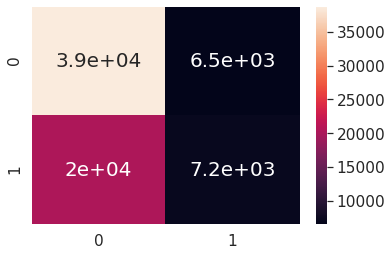

In [28]:
prediction = xgb.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

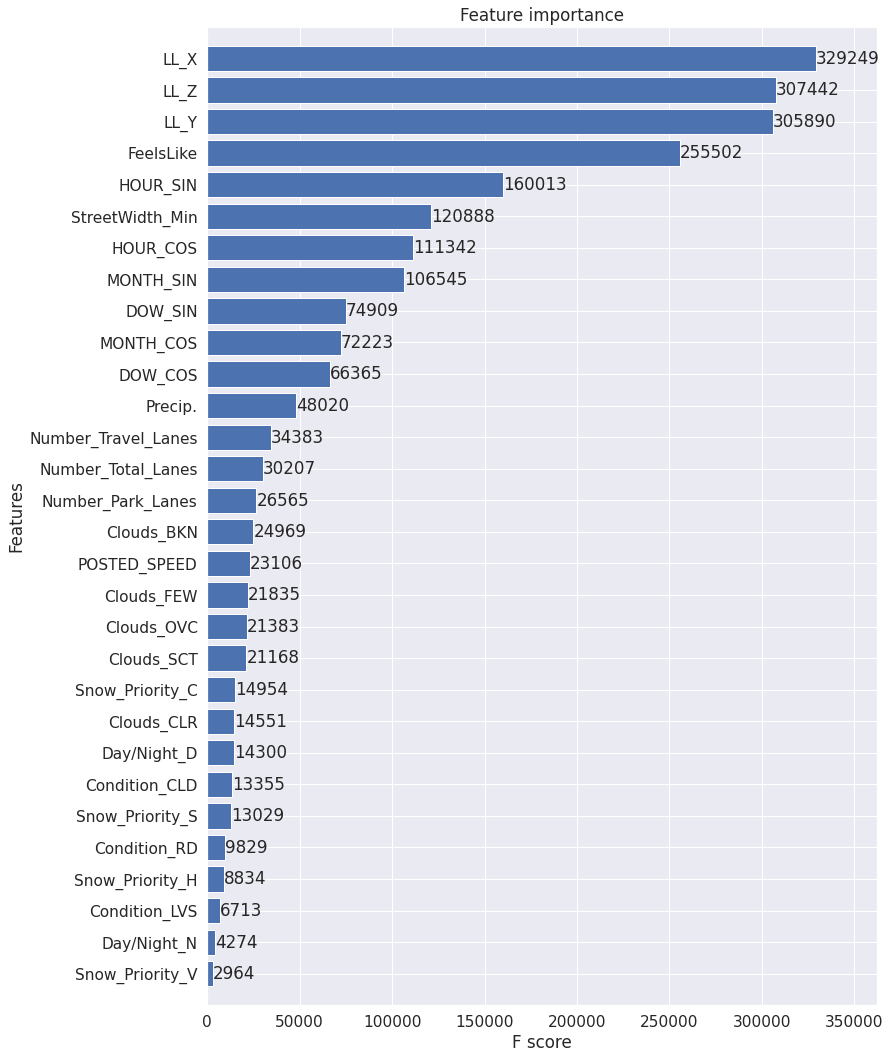

In [32]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,18))
plot_importance(xgb, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [33]:
xgb.save_model('model.json')

# max_delta_step = 1

# BLA BLA BLA

In [30]:
from xgboost import XGBClassifier
from sklearn.utils import compute_sample_weight
from sklearn.model_selection import cross_val_score, StratifiedKFold

class_weights = compute_sample_weight('balanced', y)
xgb = XGBClassifier(objective='multi:softmax', random_state=42,
          eval_metric='merror', num_class=2,
          use_label_encoder=False)

kfold = StratifiedKFold(n_splits=10)
results = cross_val_score(xgb, x, y, cv=kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#xgb.fit(x, y, sample_weight=class_weights)

Accuracy: 81.32% (0.01%)


Accuracy: 
 0.5757600781755371 
 F1: 
 0.5757600781755371 
 F1_2: 
 0.6217238330345687 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.57      0.68     58912
           1       0.25      0.61      0.35     13745

    accuracy                           0.58     72657
   macro avg       0.55      0.59      0.52     72657
weighted avg       0.75      0.58      0.62     72657

[[33482  5394]
 [25430  8351]]


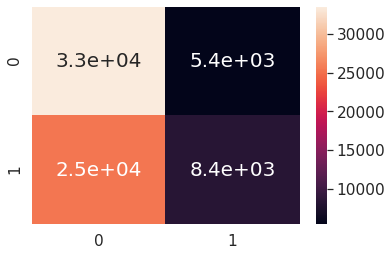

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, classification_report

prediction = xgb.predict_proba(x_test).argmax(axis=1)
accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')

print(confusion_matrix(prediction, y_test))

sns.set(font_scale=1.4) # for label size
sns.heatmap(confusion_matrix(prediction, y_test), annot=True, annot_kws={"size": 20})

plt.show()

In [17]:
cat.fit(x, y)
ada.fit(x, y)
extra_tree.fit(x, y)
lgbm.fit(x, y)
xgb.fit(x, y)

Training loop started [Tue Apr 27 19:19:22 2021]
Learning rate set to 0.164119
0:	learn: 0.6894567	total: 412ms	remaining: 6m 51s
50:	learn: 0.6736503	total: 15.6s	remaining: 4m 49s
100:	learn: 0.6706214	total: 27.5s	remaining: 4m 4s
150:	learn: 0.6681736	total: 37s	remaining: 3m 27s
200:	learn: 0.6661618	total: 48.2s	remaining: 3m 11s
250:	learn: 0.6643232	total: 59.3s	remaining: 2m 57s
300:	learn: 0.6626091	total: 1m 9s	remaining: 2m 41s
350:	learn: 0.6610284	total: 1m 23s	remaining: 2m 34s
400:	learn: 0.6595602	total: 1m 36s	remaining: 2m 24s
450:	learn: 0.6580575	total: 1m 51s	remaining: 2m 15s
500:	learn: 0.6566914	total: 2m 3s	remaining: 2m 2s
550:	learn: 0.6553738	total: 2m 16s	remaining: 1m 51s
600:	learn: 0.6540774	total: 2m 29s	remaining: 1m 39s
650:	learn: 0.6528105	total: 2m 42s	remaining: 1m 27s
700:	learn: 0.6515330	total: 2m 56s	remaining: 1m 15s
750:	learn: 0.6503387	total: 3m 7s	remaining: 1m 2s
800:	learn: 0.6491756	total: 3m 20s	remaining: 49.9s
850:	learn: 0.6479715

AttributeError: 'XGBClassifier' object has no attribute 'objective'

AttributeError: 'XGBClassifier' object has no attribute 'objective'

In [18]:
cat.classification_report(x_test, y_test)

Accuracy: 
 0.5833711824049989 
 F1: 
 0.5833711824049989 
 F1_2: 
 0.6284891972405653 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.58      0.69     58912
           1       0.25      0.60      0.35     13745

    accuracy                           0.58     72657
   macro avg       0.56      0.59      0.52     72657
weighted avg       0.75      0.58      0.63     72657



In [19]:
ada.classification_report(x_test, y_test)

Accuracy: 
 0.8108234581664533 
 F1: 
 0.8108234581664533 
 F1_2: 
 0.7261168142571898 
 Classification report: 
               precision    recall  f1-score   support

           0       0.81      1.00      0.90     58912
           1       0.00      0.00      0.00     13745

    accuracy                           0.81     72657
   macro avg       0.41      0.50      0.45     72657
weighted avg       0.66      0.81      0.73     72657



/home/djordje/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djordje/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/djordje/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
extra_tree.classification_report(x_test, y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  

In [21]:
lgbm.classification_report(x_test, y_test)

Accuracy: 
 0.5684930564157618 
 F1: 
 0.5684930564157618 
 F1_2: 
 0.6151911393220311 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.56      0.68     58912
           1       0.24      0.61      0.35     13745

    accuracy                           0.57     72657
   macro avg       0.55      0.58      0.51     72657
weighted avg       0.74      0.57      0.62     72657



In [22]:
xgb.classification_report(x_test, y_test)


Accuracy: 
 0.5757600781755371 
 F1: 
 0.5757600781755371 
 F1_2: 
 0.6217238330345687 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.57      0.68     58912
           1       0.25      0.61      0.35     13745

    accuracy                           0.58     72657
   macro avg       0.55      0.59      0.52     72657
weighted avg       0.75      0.58      0.62     72657



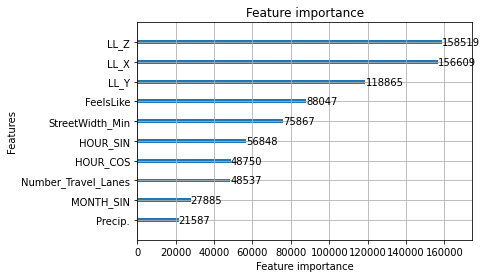

In [23]:
cat.feature_importance(x_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

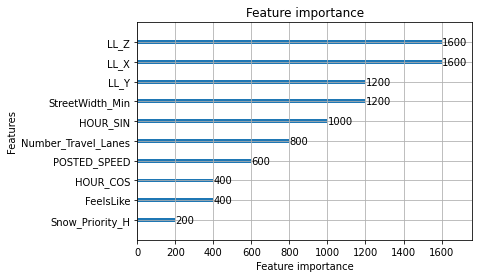

In [24]:
ada.feature_importance(x_test)

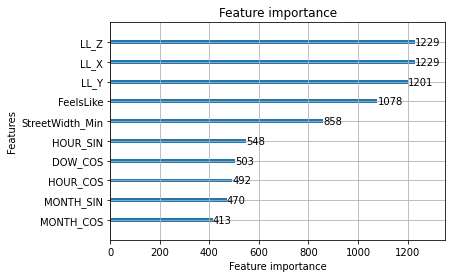

In [25]:
extra_tree.feature_importance(x_test)

In [26]:
lgbm.feature_importance(x_test)

TypeError: feature_importance() takes 1 positional argument but 2 were given

In [ ]:
xgb.feature_importance(x_test)

ENSAMBLE

In [48]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

# best perfoming models
p1 = cat.model.predict_proba(x_test)
p2 = lgbm.model.predict_proba(x_test)

prediction = (p1 + p2)/2
prediction = prediction.argmax(axis=1)

accuracy = accuracy_score(y_test, prediction)
f1 = f1_score(y_test, prediction, average='micro')
f1_2 = f1_score(y_test, prediction, average='weighted')
report = classification_report(y_test, prediction)

print(f'Accuracy: \n {accuracy} \n F1: \n {f1} \n F1_2: \n {f1_2} \n Classification report: \n {report}')


Accuracy: 
 0.579792724720261 
 F1: 
 0.579792724720261 
 F1_2: 
 0.625320864017317 
 Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.57      0.69     58912
           1       0.25      0.61      0.35     13745

    accuracy                           0.58     72657
   macro avg       0.56      0.59      0.52     72657
weighted avg       0.75      0.58      0.63     72657

